In [ ]:
# download SHANGHAITECH crowd dataset from here
# https://www.kaggle.com/datasets/tthien/shanghaitech

In [2]:
import json
import cv2
from pprint import pprint
from scipy.io import loadmat
import os
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

In [3]:
train_mat_path = "./ShanghaiTech/part_A/train_data/ground-truth"
train_image_path = "./ShanghaiTech/part_A/train_data/images"

test_mat_path = "./ShanghaiTech/part_A/test_data/ground-truth"
test_image_path = "./ShanghaiTech/part_A/test_data/images"

In [6]:
mat_path = train_mat_path
mat_files = os.listdir(train_mat_path)
for mat_file in mat_files:    
    m_path = os.path.join(mat_path, mat_file)
    mat = loadmat(m_path)
    coords = mat["image_info"][0][0][0][0][0]
    assert len(coords) > 0, "empty"

In [84]:
def convert_shanghaitech_to_coco(image_path, mat_path, subset=None):
    coco = {}
    coco["info"] = {}
    coco["info"]["description"] = "ShanghaiTech dataset"
    coco["categories"] = [{"id": 1, "name": "person", "supercategory": "person"}]
    coco["annotations"] = []
    coco["images"] = []
    image_id = 1
    keypoint_id = 1
    mat_files = os.listdir(mat_path)
    np.random.seed(0)
    np.random.shuffle(mat_files)
    
    # if you want to perform CV on entire trian. maybe you dont have to split.
    if subset=="train":
        mat_files = mat_files[:int(len(mat_files)*0.8)]
    elif subset=="val":
        mat_files = mat_files[int(len(mat_files)*0.8):]

    for mat_file in mat_files:
        
        m_path = os.path.join(mat_path, mat_file)
        basename = os.path.splitext(mat_file)[0].replace("GT_", "")
        i_path = os.path.join(image_path, basename + ".jpg")
        assert os.path.exists(m_path), f"{m_path} not found"
        assert os.path.exists(i_path), f"{i_path} not found"
        
        # create dict for coco["images"]
        img = cv2.imread(i_path)
        _image = {}
        _image["id"] = int(image_id)
        _image["file_name"] = basename + ".jpg"
        _image["width"] = int(img.shape[1])
        _image["height"] = int(img.shape[0])
        coco["images"].append(_image)

        # create dict for coco["annotations"]
        mat = loadmat(m_path)
        coords = mat["image_info"][0][0][0][0][0]

        # this dataset is a keypoint, but to keep consistency with the bbox format code, we use bbox with width and height size 0.
        for coord in coords:
            _ann = {}
            _ann["id"] = int(keypoint_id)
            _ann["image_id"] = int(image_id)
            _ann["iscrowd"] = 0
            _ann["area"] = 0
            _ann["category_id"] = 1
            _ann["bbox"] = [coord[0], coord[1], 0, 0]
            coco["annotations"].append(_ann)
            keypoint_id += 1
        image_id += 1
    return coco
        
coco = convert_shanghaitech_to_coco(train_image_path, train_mat_path,subset="train")
with open("shanghaitech_train.json", "w") as f:
    json.dump(coco, f)
coco = convert_shanghaitech_to_coco(train_image_path, train_mat_path,subset="val")
with open("shanghaitech_val.json", "w") as f:
    json.dump(coco, f)
coco = convert_shanghaitech_to_coco(test_image_path, test_mat_path)
with open("shanghaitech_test.json", "w") as f:
    json.dump(coco, f)


loading annotations into memory...
Done (t=0.66s)
creating index...
index created!


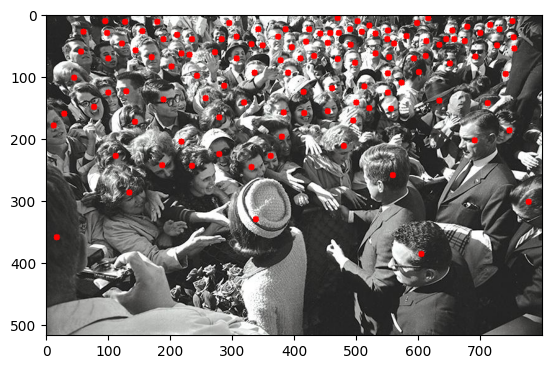

In [80]:
#load img and annotations from coco
coco = COCO("shanghaitech_train.json")
img_id = coco.getImgIds()[0]
img = coco.loadImgs(img_id)[0]
img_path = os.path.join(train_image_path, img["file_name"])
image = cv2.imread(img_path)
anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))

for ann in anns:
    x, y, w, h = ann["bbox"]
    cv2.circle(image, (int(x), int(y)), 5, (0, 0, 255), -1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))